<a href="https://colab.research.google.com/github/2303a51060Nirnaya/PythonForDataScience/blob/main/fakenewsdetection1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#supervised


In [1]:
# Step5_supervised.py  -- paste into Colab and run
!pip install -q xgboost joblib

import os, sys
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from joblib import dump

# -------------- load files (adjust paths if necessary) --------------
paths = ["/content/Fake.csv", "/content/True.csv", "/content/Fake.csv", "/content/True.csv"]
fake_path = true_path = None
if os.path.exists("/content/Fake.csv") and os.path.exists("/content/True.csv"):
    fake_path, true_path = "/content/Fake.csv", "/content/True.csv"
elif os.path.exists("/content/Fake.csv") and os.path.exists("/content/True.csv"):
    fake_path, true_path = "/content/Fake.csv", "/content/True.csv"
else:
    raise FileNotFoundError("Upload Fake.csv and True.csv to /content or ensure /mnt/data paths are present.")

fake = pd.read_csv(fake_path, engine="python", encoding="utf-8")
true = pd.read_csv(true_path, engine="python", encoding="utf-8")
fake['label'] = 'fake'; true['label'] = 'true'

# -------------- prepare data --------------
for df in (fake, true):
    for c in ['title','text']:
        if c not in df.columns:
            df[c] = ""
df = pd.concat([fake[['title','text','label']], true[['title','text','label']]], ignore_index=True)
df['content'] = (df['title'].fillna("") + " " + df['text'].fillna("")).str.strip()
df['label_enc'] = df['label'].map({'true':0,'fake':1})

print("Class counts:\n", df['label'].value_counts())

# -------------- optional: sample to speed up (None = full) --------------
sample_size = None   # set e.g. 15000 to subsample
if sample_size and len(df) > sample_size:
    df = df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=sample_size/len(df), random_state=42)).reset_index(drop=True)
    print("Using sample:", len(df))

X = df['content'].values; y = df['label_enc'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

# -------------- vectorize --------------
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2), stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

# -------------- models to run --------------
models = {
    "MultinomialNB": MultinomialNB(),
    "LogisticRegression": LogisticRegression(max_iter=1000, solver='liblinear'),
    "LinearSVC": LinearSVC(max_iter=5000),
    "RandomForest": RandomForestClassifier(n_estimators=150, n_jobs=-1, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0)
}

results = []
best_f1 = -1; best_name=None; best_obj=None

for name, m in models.items():
    print("\n---", name, "---")
    m.fit(X_train_tfidf, y_train)
    y_pred = m.predict(X_test_tfidf)
    print("Accuracy:", round(accuracy_score(y_test,y_pred),5))
    print(classification_report(y_test,y_pred,target_names=['true','fake'], zero_division=0))
    p,r,f1,_ = precision_recall_fscore_support(y_test,y_pred, average='binary', zero_division=0)
    results.append({"model":name,"accuracy":accuracy_score(y_test,y_pred),"precision":p,"recall":r,"f1":f1})
    if f1 > best_f1:
        best_f1 = f1; best_name = name; best_obj = m

# save summary and best pipeline
res_df = pd.DataFrame(results).sort_values('f1', ascending=False).reset_index(drop=True)
print("\nSummary:\n", res_df)
res_df.to_csv("/content/supervised_summary.csv", index=False)
if best_obj is not None:
    from sklearn.pipeline import Pipeline
    pipeline = Pipeline([('tfidf', tfidf), ('model', best_obj)])
    dump(pipeline, f"/content/best_model_{best_name}.joblib")
    print("Saved:", f"/content/best_model_{best_name}.joblib")


Class counts:
 label
fake    23481
true    21417
Name: count, dtype: int64

--- MultinomialNB ---
Accuracy: 0.95134
              precision    recall  f1-score   support

        true       0.95      0.95      0.95      4284
        fake       0.96      0.95      0.95      4696

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980


--- LogisticRegression ---
Accuracy: 0.98964
              precision    recall  f1-score   support

        true       0.99      0.99      0.99      4284
        fake       0.99      0.99      0.99      4696

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980


--- LinearSVC ---
Accuracy: 0.99577
              precision    recall  f1-score   support

        true       1.00      1.00      1.00      4284
        fake       1.00      1.00     

#unsupervised


Using 6000 documents for clustering
KMeans silhouette: 0.012246422610676976
Agglomerative silhouette (approx): 0.008755048424100565
DBSCAN produced 1 clusters (maybe noise)


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


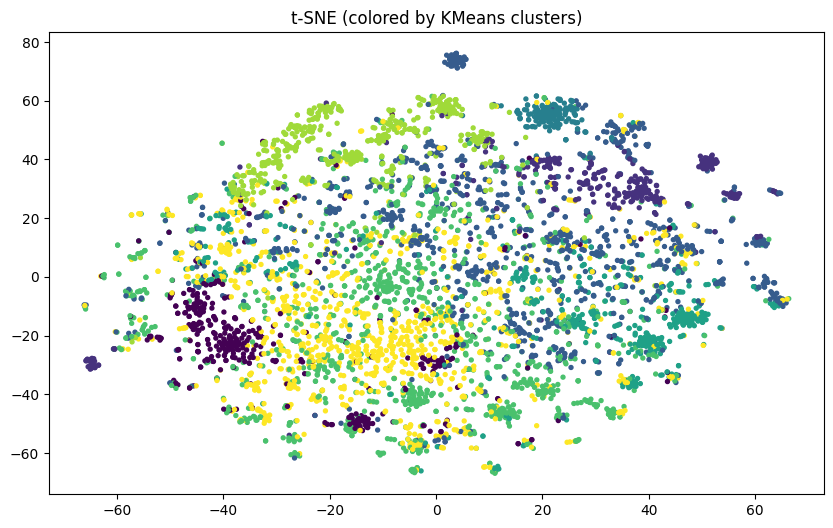

In [5]:
!pip install -q umap-learn

import os, pandas as pd, numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# load data (same logic as Step5)
if os.path.exists("/content/Fake.csv") and os.path.exists("/content/True.csv"):
    fake = pd.read_csv("/content/Fake.csv", engine="python", encoding="utf-8")
    true = pd.read_csv("/content/True.csv", engine="python", encoding="utf-8")
elif os.path.exists("/content/Fake.csv"):
    fake = pd.read_csv("/content/Fake.csv", engine="python", encoding="utf-8")
    true = pd.read_csv("/content/True.csv", engine="python", encoding="utf-8")
else:
    raise FileNotFoundError("/content/Fake.csv and /content/True.csv")

for df in (fake,true):
    for c in ['title','text']:
        if c not in df.columns: df[c] = ""
df = pd.concat([fake[['title','text']], true[['title','text']]], ignore_index=True)
df['content'] = (df['title'].fillna("") + " " + df['text'].fillna("")).str.strip()

# sample for speed
sample_n = 6000
if len(df) > sample_n:
    df = df.sample(sample_n, random_state=42).reset_index(drop=True)
print("Using", len(df), "documents for clustering")

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
X = tfidf.fit_transform(df['content'])

# ------------ KMeans --------------
k = 8
km = KMeans(n_clusters=k, random_state=42, n_init=10)
km_labels = km.fit_predict(X)
print("KMeans silhouette:", silhouette_score(X, km_labels))

# ------------ Agglomerative --------------
agg = AgglomerativeClustering(n_clusters=k)
agg_labels = agg.fit_predict(X.toarray() if hasattr(X, "toarray") else X)
print("Agglomerative silhouette (approx):", silhouette_score(X, agg_labels))

# ------------ DBSCAN --------------
db = DBSCAN(eps=0.8, min_samples=6, metric='cosine')
db_labels = db.fit_predict(X)
db_valid = len(set(db_labels)) - (1 if -1 in db_labels else 0)
if db_valid > 1:
    print("DBSCAN silhouette:", silhouette_score(X, db_labels))
else:
    print("DBSCAN produced", db_valid, "clusters (maybe noise)")

# ------------ t-SNE plot (2D) --------------
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=800)
X2 = tsne.fit_transform(np.asarray(X.todense()) if hasattr(X, "todense") else X)
plt.figure(figsize=(10,6))
plt.scatter(X2[:,0], X2[:,1], c=km_labels, s=8)
plt.title("t-SNE (colored by KMeans clusters)")
plt.show()

#deeplearning


In [7]:
!pip install -q tensorflow

import os, pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# load data
if os.path.exists("/content/Fake.csv"):
    fake = pd.read_csv("/content/Fake.csv", engine="python", encoding="utf-8")
    true = pd.read_csv("/content/True.csv", engine="python", encoding="utf-8")
else:
    fake = pd.read_csv("/content/Fake.csv", engine="python", encoding="utf-8")
    true = pd.read_csv("/content/True.csv", engine="python", encoding="utf-8")
for df in (fake,true):
    for c in ['title','text']:
        if c not in df.columns: c
        if c not in df.columns: df[c] = ""
df = pd.concat([fake[['title','text']].assign(label=1), true[['title','text']].assign(label=0)], ignore_index=True)
df['content'] = (df['title'].fillna("") + " " + df['text'].fillna("")).str.strip()
df = df.sample(20000, random_state=42) if len(df)>20000 else df

X = df['content'].values; y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

# Tokenize
vocab_size = 20000
maxlen = 200
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
seq_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=maxlen)
seq_test  = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=maxlen)

# Model: Embedding -> Conv1D -> GlobalMaxPool -> Dense
model = keras.Sequential([
    layers.Embedding(vocab_size, 128, input_length=maxlen),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train (use small epochs; adjust as needed)
history = model.fit(seq_train, y_train, validation_split=0.1, epochs=4, batch_size=128)

# Evaluate
loss, acc = model.evaluate(seq_test, y_test, verbose=0)
print("Test acc:", acc)
preds = (model.predict(seq_test) > 0.5).astype(int).flatten()
from sklearn.metrics import classification_report
print(classification_report(y_test, preds, target_names=['true','fake'], zero_division=0))

# Save model
model.save("/content/text_cnn_model.keras")
print("Model saved to /content/text_cnn_model.keras")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/4
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 348ms/step - accuracy: 0.7873 - loss: 0.4386 - val_accuracy: 0.9762 - val_loss: 0.0640
Epoch 2/4
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 353ms/step - accuracy: 0.9865 - loss: 0.0373 - val_accuracy: 0.9844 - val_loss: 0.0444
Epoch 3/4
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 351ms/step - accuracy: 0.9988 - loss: 0.0064 - val_accuracy: 0.9837 - val_loss: 0.0469
Epoch 4/4
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 359ms/step - accuracy: 0.9998 - loss: 0.0018 - val_accuracy: 0.9850 - val_loss: 0.0506
Test acc: 0.9854999780654907
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
              precision    recall  f1-score   support

        true       0.98      0.99      0.98      1909
        fake       0.99      0.98      0.99      2091

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000

Model saved to /content/text_cnn_model.keras


#Reinforcement

In [8]:
!pip install -q torch

import os, random
import numpy as np, pandas as pd
import torch, torch.nn as nn, torch.optim as optim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# load data
if os.path.exists("/content/Fake.csv"):
    fake = pd.read_csv("/content/Fake.csv", engine="python", encoding="utf-8")
    true = pd.read_csv("/content/True.csv", engine="python", encoding="utf-8")
else:
    fake = pd.read_csv("/content/Fake.csv", engine="python", encoding="utf-8")
    true = pd.read_csv("/content/True.csv", engine="python", encoding="utf-8")

for df in (fake,true):
    for c in ['title','text']:
        if c not in df.columns: df[c] = ""
df = pd.concat([fake[['title','text']].assign(label=1), true[['title','text']].assign(label=0)], ignore_index=True)
df['content'] = (df['title'].fillna("") + " " + df['text'].fillna("")).str.strip()
df = df.sample(8000, random_state=42).reset_index(drop=True)  # small subset for speed

X = df['content'].values; y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

tfidf = TfidfVectorizer(max_features=2000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# simple policy network: input -> hidden -> 2-action logits
class PolicyNet(nn.Module):
    def __init__(self, in_dim, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 2)  # logits for 2 actions
        )
    def forward(self, x):
        return self.net(x)

policy = PolicyNet(X_train_tfidf.shape[1]).to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-3)

# REINFORCE-style training loop
def train_epoch(policy, X, y, optimizer, batch_size=64):
    policy.train()
    n = len(X)
    idx = np.arange(n)
    np.random.shuffle(idx)
    total_loss = 0.0; total_reward = 0.0
    for i in range(0, n, batch_size):
        batch_idx = idx[i:i+batch_size]
        xb = torch.tensor(X[batch_idx], dtype=torch.float32, device=device)
        yb = torch.tensor(y[batch_idx], dtype=torch.long, device=device)
        logits = policy(xb)
        probs = torch.softmax(logits, dim=1)
        dist = torch.distributions.Categorical(probs)
        actions = dist.sample()  # sampled actions
        rewards = (actions == yb).float()  # reward=1 if correct
        # compute policy loss: -E[ reward * log_prob(action) ]
        logp = dist.log_prob(actions)
        loss = -(logp * rewards).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(batch_idx)
        total_reward += rewards.sum().item()
    return total_loss / n, total_reward / n

# train for a few epochs
for epoch in range(1, 9):
    loss, avg_reward = train_epoch(policy, X_train_tfidf, y_train, optimizer, batch_size=128)
    print(f"Epoch {epoch}: loss={loss:.4f}, avg_reward={avg_reward:.4f}")

# evaluate greedy policy on test set:
policy.eval()
with torch.no_grad():
    xb = torch.tensor(X_test_tfidf, dtype=torch.float32, device=device)
    logits = policy(xb)
    preds = logits.argmax(dim=1).cpu().numpy()
from sklearn.metrics import classification_report, accuracy_score
print("Test accuracy (RL policy):", accuracy_score(y_test, preds))
print(classification_report(y_test, preds, target_names=['true','fake'], zero_division=0))


Epoch 1: loss=0.2970, avg_reward=0.5953
Epoch 2: loss=0.1187, avg_reward=0.8520
Epoch 3: loss=0.0569, avg_reward=0.9227
Epoch 4: loss=0.0366, avg_reward=0.9503
Epoch 5: loss=0.0273, avg_reward=0.9586
Epoch 6: loss=0.0203, avg_reward=0.9680
Epoch 7: loss=0.0175, avg_reward=0.9728
Epoch 8: loss=0.0137, avg_reward=0.9794
Test accuracy (RL policy): 0.96875
              precision    recall  f1-score   support

        true       0.97      0.97      0.97       762
        fake       0.97      0.97      0.97       838

    accuracy                           0.97      1600
   macro avg       0.97      0.97      0.97      1600
weighted avg       0.97      0.97      0.97      1600

